<a href="https://colab.research.google.com/github/YushkevichNV/HomeCredit/blob/main/HomeCredit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Home Credit Default Risk**


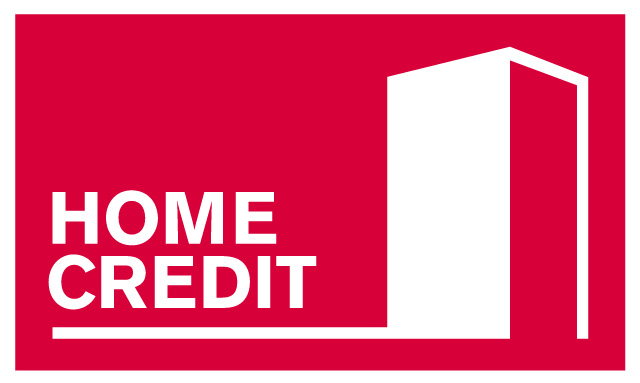

# import

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import TruncatedSVD

# **Loading data.**

https://www.kaggle.com/competitions/home-credit-default-risk/overview

In [ ]:
# Google drive
from google.colab import drive

drive.mount('/content/gdrive/')
root_path = 'gdrive/My Drive/'  

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#kaggle API
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"nataliamakferson","key":"a2972f9b0896a2d96262a61107b64749"}'}

In [ ]:
!pip install kaggle==1.5.6
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json  

#Loading dataset
!kaggle competitions download -c home-credit-default-risk
!unzip -q /content/home-credit-default-risk.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
home-credit-default-risk.zip: Skipping, found more recently modified local copy (use --force to force download)
replace HomeCredit_columns_description.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace POS_CASH_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# **Data preparation.**

We define the training and test datasets.

In [ ]:
data = pd.read_csv('/content/application_train.csv')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_data = pd.read_csv('/content/application_test.csv')
test_data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Uploading the rest of the files.

In [ ]:
bureau = pd.read_csv('/content/bureau.csv')
bureau_balance = pd.read_csv('/content/bureau_balance.csv')
POS_CASH_balance = pd.read_csv('/content/POS_CASH_balance.csv')
credit_card_balance = pd.read_csv('/content/credit_card_balance.csv')
previous_application = pd.read_csv('/content/previous_application.csv')
installments_payments = pd.read_csv('/content/installments_payments.csv')

Let's see what the columns in each of the files describe (the description is in the "HomeCredit_columns_description.csv" file).

In [ ]:
with open('/content/HomeCredit_columns_description.csv', 'r', newline='', encoding='ISO-8859-1') as csvfile:
  columns_description = pd.read_csv(csvfile, index_col=0)
columns_description

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


# **EDA**

The train and test datasets have the same columns except for 'TARGET' - this is the column with the variable to be predicted.
Therefore, we will analyze them in parallel.

We delete columns that, in our opinion, do not affect TARGET or correlate.

In [ ]:
data['AMT_REQ_CREDIT_BUREAU_YEAR_ALL'] = data['AMT_REQ_CREDIT_BUREAU_HOUR']+data['AMT_REQ_CREDIT_BUREAU_DAY']+data['AMT_REQ_CREDIT_BUREAU_WEEK']+\
data['AMT_REQ_CREDIT_BUREAU_MON']+data['AMT_REQ_CREDIT_BUREAU_QRT']+data['AMT_REQ_CREDIT_BUREAU_YEAR']

In [ ]:
test_data['AMT_REQ_CREDIT_BUREAU_YEAR_ALL'] = test_data['AMT_REQ_CREDIT_BUREAU_HOUR']+test_data['AMT_REQ_CREDIT_BUREAU_DAY']+test_data['AMT_REQ_CREDIT_BUREAU_WEEK']+\
test_data['AMT_REQ_CREDIT_BUREAU_MON']+test_data['AMT_REQ_CREDIT_BUREAU_QRT']+test_data['AMT_REQ_CREDIT_BUREAU_YEAR']

In [ ]:
drop_col = ['NAME_TYPE_SUITE', 'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL', 'OCCUPATION_TYPE', \
            'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'REG_REGION_NOT_LIVE_REGION' ,'REG_REGION_NOT_WORK_REGION' ,'LIVE_REGION_NOT_WORK_REGION',\
            'REG_CITY_NOT_LIVE_CITY' ,'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY','APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',\
            'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG','ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG','LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',\
            'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',\
            'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE','ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE','LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',\
            'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE','APARTMENTS_MEDI', 'BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',\
            'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI','FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',\
            'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE','HOUSETYPE_MODE','TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE',\
            'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT',\
            'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_REGISTRATION']
for col in drop_col:
  data =data.drop([col], axis=1)
  test_data =test_data.drop([col], axis=1)

We build a correlation matrix and remove strongly correlated features.

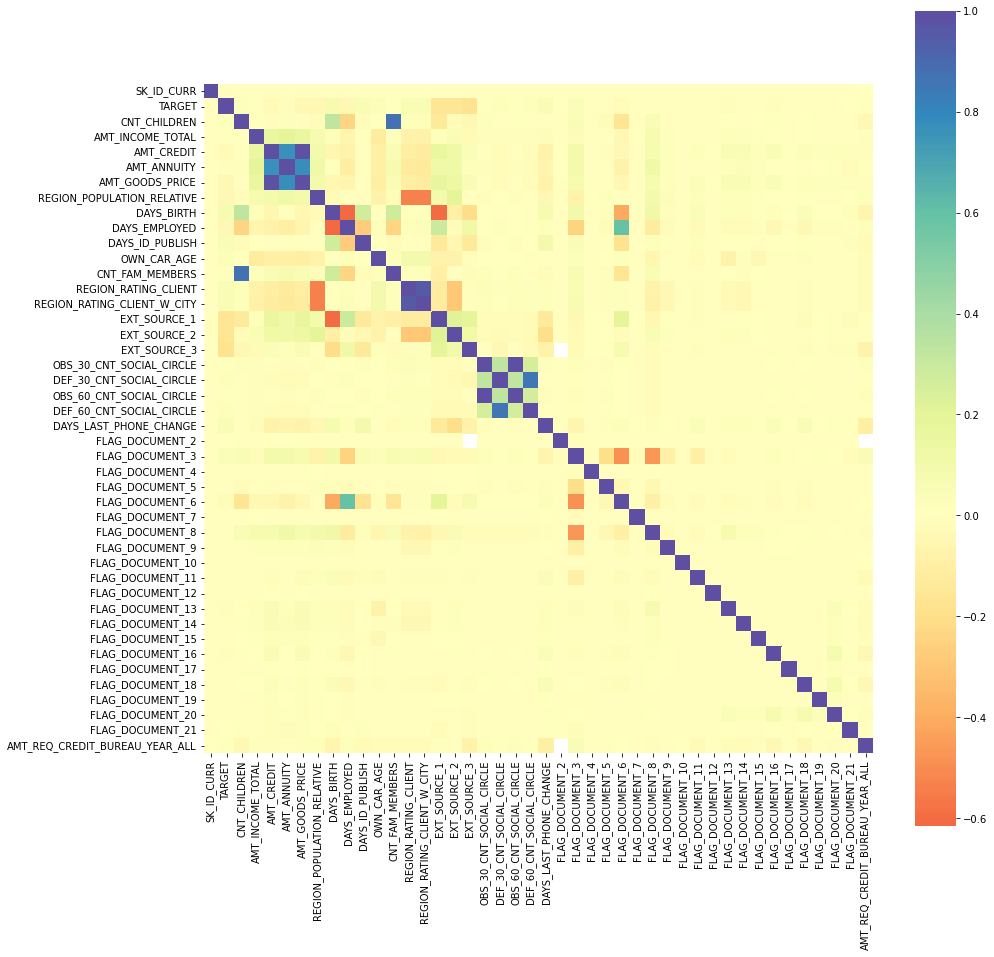

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(method='pearson'), center=0, square=True,cmap='Spectral')
plt.show()

In [ ]:
correlation_matrix = data.corr(method = 'pearson')
corr_col = {}
columns = correlation_matrix.columns[:-1]
for i in range(len(columns)):
  col = columns[i]
  cols = columns[:(i+1)]  
  corr_list = correlation_matrix[col][(i+1):][np.abs(correlation_matrix[col][(i+1):])>0.9].index.tolist()
  if corr_list!=[]:
    corr_col[col] = corr_list

In [ ]:
corr_col

{'AMT_CREDIT': ['AMT_GOODS_PRICE'],
 'OBS_30_CNT_SOCIAL_CIRCLE': ['OBS_60_CNT_SOCIAL_CIRCLE'],
 'REGION_RATING_CLIENT': ['REGION_RATING_CLIENT_W_CITY']}

In [ ]:
drop_col = ['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT','OBS_60_CNT_SOCIAL_CIRCLE']
for col in drop_col:
  data =data.drop([col], axis=1)
  test_data =test_data.drop([col], axis=1)

**Missing values.**

In [ ]:
col_name_train = []
for col, per in zip(data.columns, (data.isnull().mean() *100)):
  if per!=0.0:
    col_name_train.append(col)
    print(col, round(per,4), '%')

AMT_ANNUITY 0.0039 %
OWN_CAR_AGE 65.9908 %
CNT_FAM_MEMBERS 0.0007 %
EXT_SOURCE_1 56.3811 %
EXT_SOURCE_2 0.2146 %
EXT_SOURCE_3 19.8253 %
OBS_30_CNT_SOCIAL_CIRCLE 0.332 %
DEF_30_CNT_SOCIAL_CIRCLE 0.332 %
DEF_60_CNT_SOCIAL_CIRCLE 0.332 %
DAYS_LAST_PHONE_CHANGE 0.0003 %
AMT_REQ_CREDIT_BUREAU_YEAR_ALL 13.5016 %


In [ ]:
col_name_test = []
for col, per in zip(test_data.columns, (test_data.isnull().mean() *100)):
  if per!=0.0:
    col_name_test.append(col)
    print(col, round(per,3), '%')

AMT_ANNUITY 0.049 %
OWN_CAR_AGE 66.289 %
EXT_SOURCE_1 42.122 %
EXT_SOURCE_2 0.016 %
EXT_SOURCE_3 17.783 %
OBS_30_CNT_SOCIAL_CIRCLE 0.059 %
DEF_30_CNT_SOCIAL_CIRCLE 0.059 %
DEF_60_CNT_SOCIAL_CIRCLE 0.059 %
AMT_REQ_CREDIT_BUREAU_YEAR_ALL 12.41 %


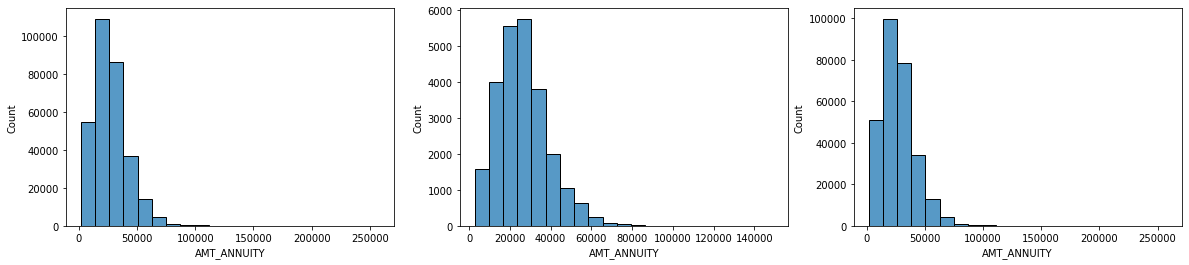

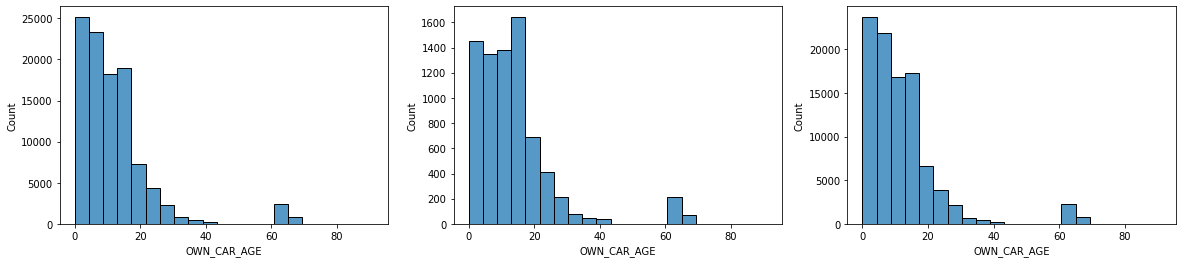

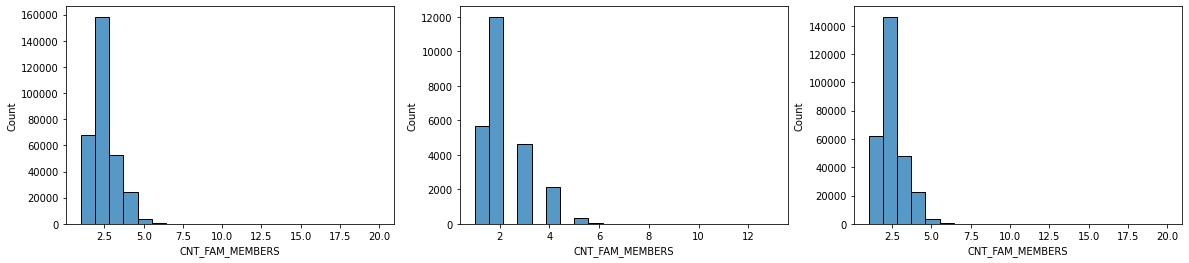

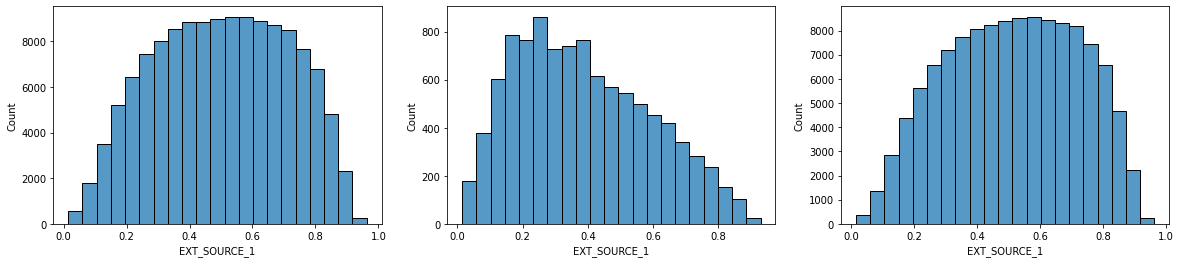

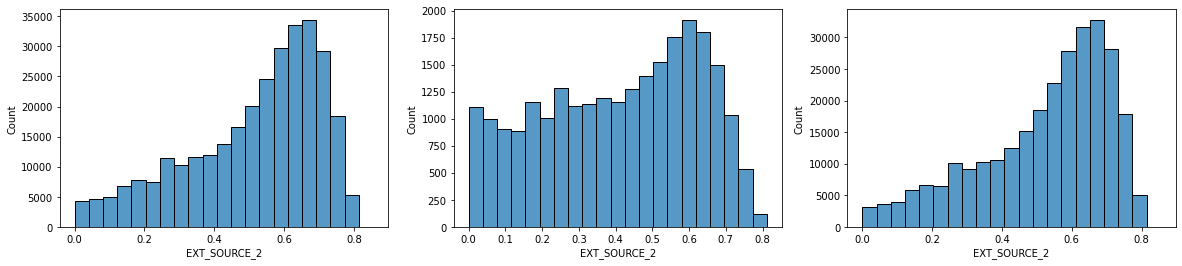

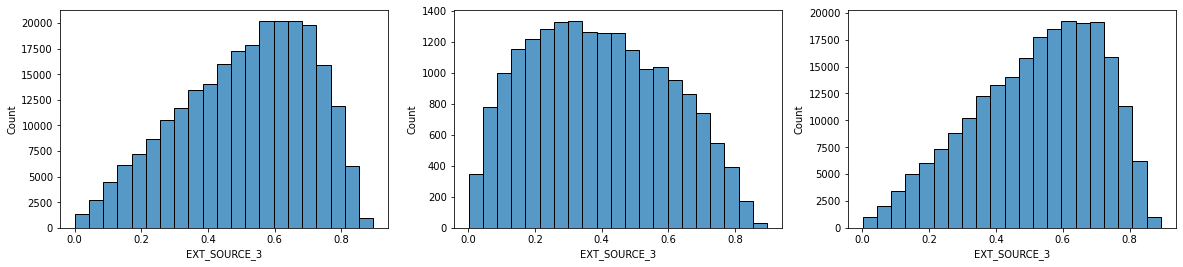

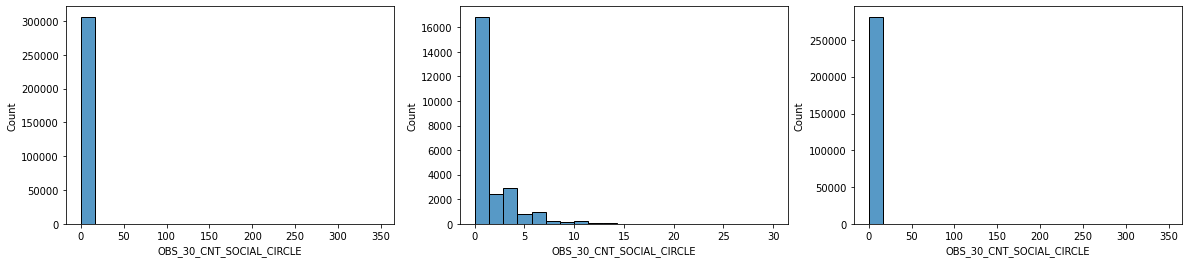

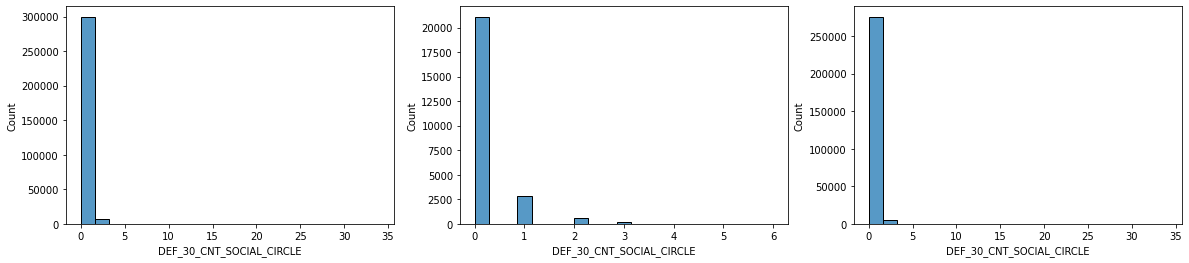

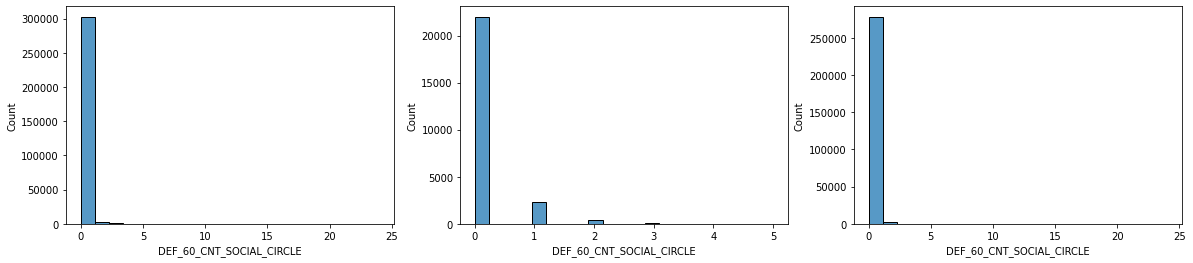

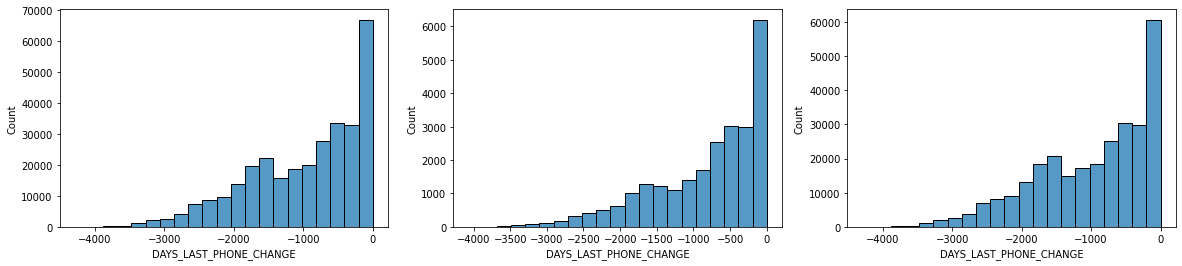

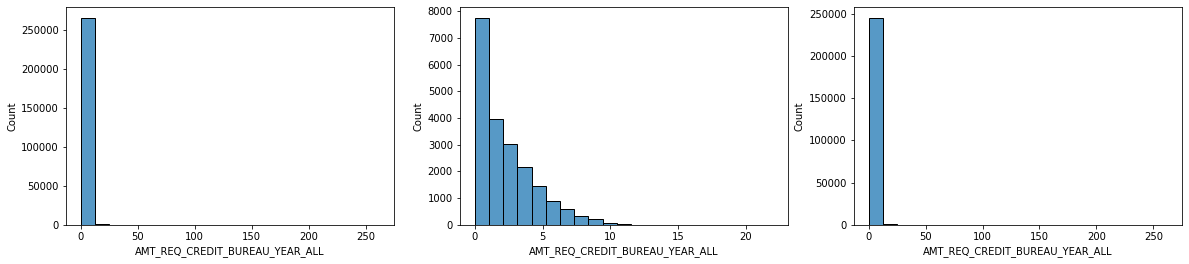

In [ ]:
for col in col_name_train:
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 3, 1)
  sns.histplot(x = data[col], bins = 21) 
  plt.subplot(1, 3, 2)
  sns.histplot(x = data[data['TARGET']==1][col], bins = 21) 
  plt.subplot(1, 3, 3)
  sns.histplot(x = data[data['TARGET']==0][col], bins = 21) 
  plt.show()

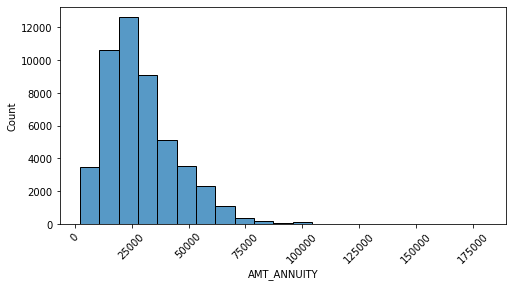

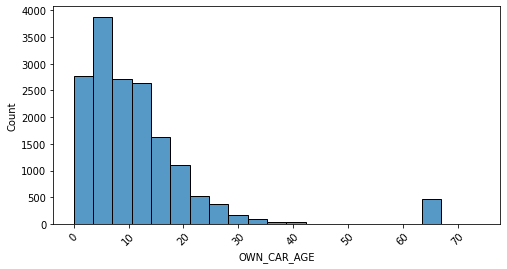

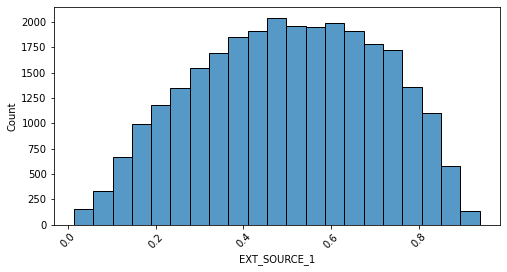

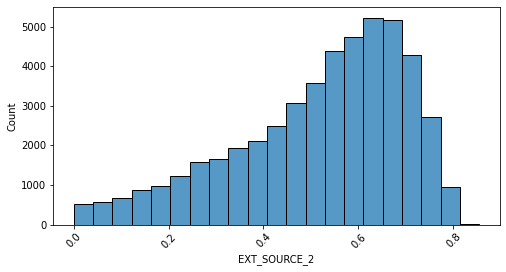

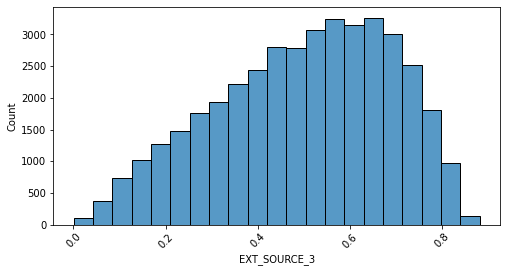

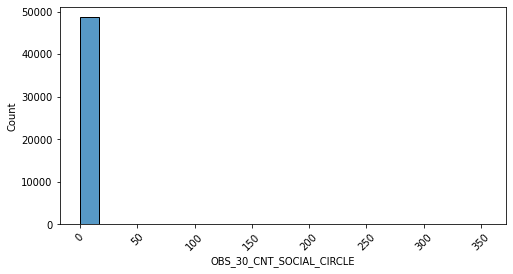

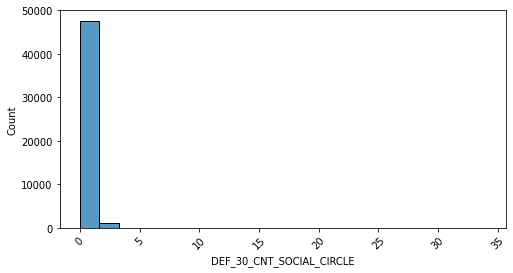

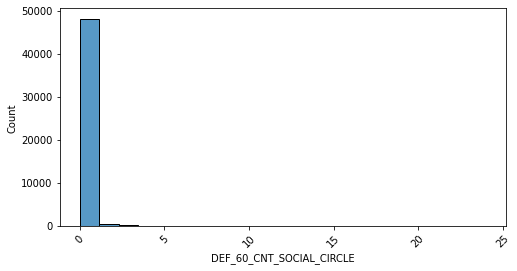

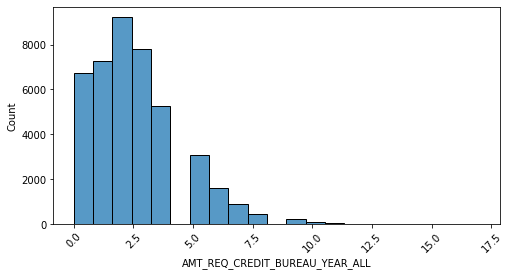

In [ ]:
for col in col_name_test:
  plt.figure(figsize=(8,4))
  sns.histplot(x = test_data[col], bins = 21)
  plt.xticks(rotation=45)
  plt.show()

We fill in the missing values based of the histograms above.

In [ ]:
data['AMT_ANNUITY'] = data['AMT_ANNUITY'].fillna(data['AMT_ANNUITY'].mean())
test_data['AMT_ANNUITY'] = test_data['AMT_ANNUITY'].fillna(data['AMT_ANNUITY'].mean())

data.loc[data['FLAG_OWN_CAR']==0, 'OWN_CAR_AGE'] = 0
test_data.loc[test_data['FLAG_OWN_CAR']==0, 'OWN_CAR_AGE'] = 0
data['OWN_CAR_AGE'] = data['OWN_CAR_AGE'].fillna(data[data['OWN_CAR_AGE'] != 0]['OWN_CAR_AGE'].mean())
test_data['OWN_CAR_AGE'] = test_data['OWN_CAR_AGE'].fillna(data[data['OWN_CAR_AGE'] != 0]['OWN_CAR_AGE'].mean())

data['CNT_FAM_MEMBERS'] = data['CNT_FAM_MEMBERS'].fillna(data['CNT_FAM_MEMBERS'].mean())

data['EXT_SOURCE_1'] = data['EXT_SOURCE_1'].fillna(data['EXT_SOURCE_1'].mean())
test_data['EXT_SOURCE_1'] = test_data['EXT_SOURCE_1'].fillna(data['EXT_SOURCE_1'].mean())

data['EXT_SOURCE_2'] = data['EXT_SOURCE_2'].fillna(data['EXT_SOURCE_2'].mean())
test_data['EXT_SOURCE_2'] = test_data['EXT_SOURCE_2'].fillna(data['EXT_SOURCE_2'].mean())

data['EXT_SOURCE_3'] = data['EXT_SOURCE_3'].fillna(data['EXT_SOURCE_3'].mean())
test_data['EXT_SOURCE_3'] = test_data['EXT_SOURCE_3'].fillna(data['EXT_SOURCE_3'].mean())

data['OBS_30_CNT_SOCIAL_CIRCLE'] = data['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0)
test_data['OBS_30_CNT_SOCIAL_CIRCLE'] = test_data['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0)

data['DEF_30_CNT_SOCIAL_CIRCLE'] = data['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0)
test_data['DEF_30_CNT_SOCIAL_CIRCLE'] = test_data['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0)

data['DEF_60_CNT_SOCIAL_CIRCLE'] = data['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)
test_data['DEF_60_CNT_SOCIAL_CIRCLE'] = test_data['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)

data['DAYS_LAST_PHONE_CHANGE'] = data['DAYS_LAST_PHONE_CHANGE'].fillna(0)

data['AMT_REQ_CREDIT_BUREAU_YEAR_ALL'] = data['AMT_REQ_CREDIT_BUREAU_YEAR_ALL'].fillna(0)
test_data['AMT_REQ_CREDIT_BUREAU_YEAR_ALL'] = test_data['AMT_REQ_CREDIT_BUREAU_YEAR_ALL'].fillna(0)

**Determine categorical features.**

In [ ]:
cat_col = []
for col in data.columns:
  if data[col].dtype == object:
    cat_col.append(col)

In [ ]:
#Number of categories in each variable
for col in cat_col:
  print(col, len(data[col].unique()), len(test_data[col].unique()))

NAME_CONTRACT_TYPE 2 2
CODE_GENDER 3 2
FLAG_OWN_CAR 2 2
FLAG_OWN_REALTY 2 2
NAME_INCOME_TYPE 8 7
NAME_EDUCATION_TYPE 5 5
NAME_FAMILY_STATUS 6 5
NAME_HOUSING_TYPE 6 6


In [ ]:
data = data.loc[data['CODE_GENDER'] != 'XNA']
data = data.loc[data['NAME_INCOME_TYPE'] != 'Maternity leave']
data = data.loc[data['NAME_FAMILY_STATUS'] != 'Unknown']

In [ ]:
for col in cat_col:
  data = pd.get_dummies(data, columns=[col], drop_first = True)
  test_data = pd.get_dummies(test_data, columns=[col], drop_first = True)

# **Bureau.csv**

In [ ]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
CREDIT_ACTIVE = bureau.groupby(by='SK_ID_CURR')['CREDIT_ACTIVE'].value_counts().unstack().fillna(0)
data = data.merge(CREDIT_ACTIVE, on=["SK_ID_CURR"], how='left')
test_data = test_data.merge(CREDIT_ACTIVE, on=["SK_ID_CURR"], how='left')

In [ ]:
CREDIT_DAY_OVERDUE = pd.DataFrame(bureau.groupby(by='SK_ID_CURR')['CREDIT_DAY_OVERDUE'].sum())
data = data.merge(CREDIT_DAY_OVERDUE, on=["SK_ID_CURR"], how='left')
test_data = test_data.merge(CREDIT_DAY_OVERDUE, on=["SK_ID_CURR"], how='left')

In [ ]:
bureau['AMT_CREDIT_MAX_OVERDUE'] = bureau['AMT_CREDIT_MAX_OVERDUE'].fillna(0)
AMT_CREDIT_MAX_OVERDUE = pd.DataFrame(bureau.groupby(by='SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].sum())
data = data.merge(AMT_CREDIT_MAX_OVERDUE, on=["SK_ID_CURR"], how='left')
test_data = test_data.merge(AMT_CREDIT_MAX_OVERDUE, on=["SK_ID_CURR"], how='left')

In [ ]:
bureau['CNT_CREDIT_PROLONG'] = bureau['CNT_CREDIT_PROLONG'].fillna(0)
CNT_CREDIT_PROLONG  = pd.DataFrame(bureau.groupby(by='SK_ID_CURR')['CNT_CREDIT_PROLONG'].sum())
data = data.merge(CNT_CREDIT_PROLONG , on=["SK_ID_CURR"], how='left')
test_data = test_data.merge(CNT_CREDIT_PROLONG, on=["SK_ID_CURR"], how='left')

In [ ]:
AMT_CREDIT_SUM_OVERDUE  = pd.DataFrame(bureau.groupby(by='SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum())
data = data.merge(AMT_CREDIT_SUM_OVERDUE , on=["SK_ID_CURR"], how='left')
test_data = test_data.merge(AMT_CREDIT_SUM_OVERDUE, on=["SK_ID_CURR"], how='left')

In [ ]:
data['Active'] = data['Active'].fillna(data['Active'].mean())
data['Bad debt'] = data['Bad debt'].fillna(data['Bad debt'].mean())
data['Closed'] = data['Closed'].fillna(data['Closed'].mean())
data['Sold'] = data['Sold'].fillna(data['Sold'].mean())
data['CREDIT_DAY_OVERDUE'] = data['CREDIT_DAY_OVERDUE'].fillna(0)
data['CNT_CREDIT_PROLONG'] = data['CNT_CREDIT_PROLONG'].fillna(0)
data['AMT_CREDIT_MAX_OVERDUE'] = data['AMT_CREDIT_MAX_OVERDUE'].fillna(0)
data['AMT_CREDIT_SUM_OVERDUE'] = data['AMT_CREDIT_SUM_OVERDUE'].fillna(0)

In [ ]:
test_data['Active'] = test_data['Active'].fillna(data['Active'].mean())
test_data['Bad debt'] = test_data['Bad debt'].fillna(data['Bad debt'].mean())
test_data['Closed'] = test_data['Closed'].fillna(data['Closed'].mean())
test_data['Sold'] = test_data['Sold'].fillna(data['Sold'].mean())
test_data['CREDIT_DAY_OVERDUE'] = test_data['CREDIT_DAY_OVERDUE'].fillna(0)
test_data['CNT_CREDIT_PROLONG'] = test_data['CNT_CREDIT_PROLONG'].fillna(0)
test_data['AMT_CREDIT_MAX_OVERDUE'] = test_data['AMT_CREDIT_MAX_OVERDUE'].fillna(0)
test_data['AMT_CREDIT_SUM_OVERDUE'] = test_data['AMT_CREDIT_SUM_OVERDUE'].fillna(0)

# credit_card_balance.**csv**

In [ ]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
MONTHS_BALANCE = pd.DataFrame(credit_card_balance.groupby(by='SK_ID_CURR')['MONTHS_BALANCE'].sum())
data = data.merge(MONTHS_BALANCE, on=["SK_ID_CURR"], how='left')
test_data = test_data.merge(MONTHS_BALANCE, on=["SK_ID_CURR"], how='left')

In [ ]:
data['MONTHS_BALANCE'] = data['MONTHS_BALANCE'].fillna(0)
test_data['MONTHS_BALANCE'] = test_data['MONTHS_BALANCE'].fillna(0)

In [ ]:
SK_DPD = pd.DataFrame(credit_card_balance.groupby(by='SK_ID_CURR')['SK_DPD'].sum())
data = data.merge(SK_DPD, on=["SK_ID_CURR"], how='left')
test_data = test_data.merge(SK_DPD, on=["SK_ID_CURR"], how='left')

In [ ]:
data['SK_DPD'] = data['SK_DPD'].fillna(0)
test_data['SK_DPD'] = test_data['SK_DPD'].fillna(0)

**Explore the target variable.**

0    282677
1     24823
Name: TARGET, dtype: int64

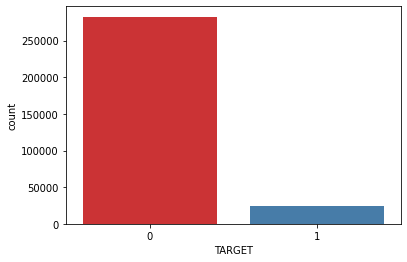

In [ ]:
sns.countplot(x = data['TARGET'], palette="Set1")
data.TARGET.value_counts()

Classes are unbalanced, as they are divided approximately in the ratio of 90% and 10%. Thus, we get that it is better not to use accyracy to assess the quality of the model (F1-score or ROC AUC would be the best choice).

It is worth using a method to deal with class imbalance.

# **Train the model.**

We have a binary classification problem with class imbalance (0 >> 1).

To assess the quality of the model, we will use ROC AUC (area under the error curve).


We will use CatBoost to train the model.


Let's use the train_test_split method to form the training and validation samples.

In [ ]:
X = data.drop(columns = ['TARGET','SK_ID_CURR']).values
y = data['TARGET'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 20)
X_test = test_data.drop(columns = 'SK_ID_CURR').values

Let's train the model on the initial data.

In [ ]:
boosting_model = catboost.CatBoostClassifier()
boosting_model.fit(X_train, y_train)

Learning rate set to 0.108109
0:	learn: 0.5842171	total: 92.3ms	remaining: 1m 32s
1:	learn: 0.5035710	total: 137ms	remaining: 1m 8s
2:	learn: 0.4445134	total: 176ms	remaining: 58.3s
3:	learn: 0.3982802	total: 295ms	remaining: 1m 13s
4:	learn: 0.3670341	total: 409ms	remaining: 1m 21s
5:	learn: 0.3405526	total: 490ms	remaining: 1m 21s
6:	learn: 0.3212167	total: 588ms	remaining: 1m 23s
7:	learn: 0.3065565	total: 633ms	remaining: 1m 18s
8:	learn: 0.2945694	total: 673ms	remaining: 1m 14s
9:	learn: 0.2873272	total: 725ms	remaining: 1m 11s
10:	learn: 0.2802004	total: 784ms	remaining: 1m 10s
11:	learn: 0.2756835	total: 844ms	remaining: 1m 9s
12:	learn: 0.2709845	total: 890ms	remaining: 1m 7s
13:	learn: 0.2674509	total: 928ms	remaining: 1m 5s
14:	learn: 0.2642409	total: 970ms	remaining: 1m 3s
15:	learn: 0.2619770	total: 1.01s	remaining: 1m 2s
16:	learn: 0.2601566	total: 1.05s	remaining: 1m
17:	learn: 0.2586869	total: 1.11s	remaining: 1m
18:	learn: 0.2575139	total: 1.21s	remaining: 1m 2s
19:	lea

Let's look at the score in the validation data.

In [ ]:
y_val_pred = boosting_model.predict_proba(X_val)[:, 1]
print(f'ROC-AUC val = {roc_auc_score(y_val, y_val_pred)}')

ROC-AUC val без подбора параметров = 0.7556660405774528


Selection of parameters for the model.

In [ ]:
CBC = catboost.CatBoostClassifier()
parameters = {'depth'         : np.arange(3, 10),
              'learning_rate' : [0.01, 0.04, 0.07, 0.09, 0.1],
              'iterations'    : [100,200,500],
              'l2_leaf_reg': np.arange(2, 20)
              }

In [ ]:
CV_model = GridSearchCV(estimator=CBC,
                        param_grid=parameters,
                        cv=3, 
                        scoring='roc_auc',
                        n_jobs=-1)
CV_model.fit(X_train, y_train)

0:	learn: 0.6010778	total: 40.6ms	remaining: 20.2s
1:	learn: 0.5284344	total: 76.8ms	remaining: 19.1s
2:	learn: 0.4726801	total: 108ms	remaining: 17.9s
3:	learn: 0.4298233	total: 142ms	remaining: 17.6s
4:	learn: 0.3972873	total: 173ms	remaining: 17.2s
5:	learn: 0.3693724	total: 214ms	remaining: 17.6s
6:	learn: 0.3462626	total: 255ms	remaining: 17.9s
7:	learn: 0.3302207	total: 294ms	remaining: 18.1s
8:	learn: 0.3159147	total: 327ms	remaining: 17.8s
9:	learn: 0.3044009	total: 366ms	remaining: 17.9s
10:	learn: 0.2951114	total: 401ms	remaining: 17.8s
11:	learn: 0.2882517	total: 432ms	remaining: 17.6s
12:	learn: 0.2823756	total: 470ms	remaining: 17.6s
13:	learn: 0.2778580	total: 507ms	remaining: 17.6s
14:	learn: 0.2739844	total: 543ms	remaining: 17.6s
15:	learn: 0.2710679	total: 573ms	remaining: 17.3s
16:	learn: 0.2681897	total: 610ms	remaining: 17.3s
17:	learn: 0.2656972	total: 650ms	remaining: 17.4s
18:	learn: 0.2635787	total: 690ms	remaining: 17.5s
19:	learn: 0.2621913	total: 725ms	remai

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd09294c950>,
             n_jobs=-1,
             param_grid={'depth': [5], 'iterations': [500], 'l2_leaf_reg': [16],
                         'learning_rate': [0.09]},
             scoring='roc_auc')

In [ ]:
print(CV_model.best_params_)

{'depth': 5, 'iterations': 500, 'l2_leaf_reg': 16, 'learning_rate': 0.09}


In [ ]:
boosting_model = catboost.CatBoostClassifier(depth=5, iterations=500, learning_rate=0.09, l2_leaf_reg=16)
boosting_model.fit(X_train, y_train)

0:	learn: 0.6010778	total: 36ms	remaining: 18s
1:	learn: 0.5284344	total: 72.5ms	remaining: 18.1s
2:	learn: 0.4726801	total: 108ms	remaining: 17.9s
3:	learn: 0.4298233	total: 141ms	remaining: 17.5s
4:	learn: 0.3972873	total: 173ms	remaining: 17.2s
5:	learn: 0.3693724	total: 215ms	remaining: 17.7s
6:	learn: 0.3462626	total: 251ms	remaining: 17.7s
7:	learn: 0.3302207	total: 290ms	remaining: 17.8s
8:	learn: 0.3159147	total: 323ms	remaining: 17.6s
9:	learn: 0.3044009	total: 363ms	remaining: 17.8s
10:	learn: 0.2951114	total: 398ms	remaining: 17.7s
11:	learn: 0.2882517	total: 433ms	remaining: 17.6s
12:	learn: 0.2823756	total: 472ms	remaining: 17.7s
13:	learn: 0.2778580	total: 512ms	remaining: 17.8s
14:	learn: 0.2739844	total: 547ms	remaining: 17.7s
15:	learn: 0.2710679	total: 578ms	remaining: 17.5s
16:	learn: 0.2681897	total: 615ms	remaining: 17.5s
17:	learn: 0.2656972	total: 651ms	remaining: 17.4s
18:	learn: 0.2635787	total: 700ms	remaining: 17.7s
19:	learn: 0.2621913	total: 735ms	remaining

In [ ]:
y_val_pred = boosting_model.predict_proba(X_val)[:, 1]
print(f'ROC-AUC val = {roc_auc_score(y_val, y_val_pred)}')

ROC-AUC val после подбора параметров = 0.7572724640523624


После подбора параметров, модель показала лучший результат.

**Data normalization.**

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
boosting_model = catboost.CatBoostClassifier(depth=5, iterations=500, learning_rate=0.09, l2_leaf_reg=16)
boosting_model.fit(X_train_scaled, y_train)

0:	learn: 0.6010778	total: 36.5ms	remaining: 18.2s
1:	learn: 0.5284344	total: 71.6ms	remaining: 17.8s
2:	learn: 0.4726801	total: 105ms	remaining: 17.4s
3:	learn: 0.4298233	total: 139ms	remaining: 17.2s
4:	learn: 0.3972873	total: 170ms	remaining: 16.9s
5:	learn: 0.3693724	total: 213ms	remaining: 17.5s
6:	learn: 0.3462626	total: 253ms	remaining: 17.8s
7:	learn: 0.3302207	total: 289ms	remaining: 17.8s
8:	learn: 0.3159147	total: 324ms	remaining: 17.6s
9:	learn: 0.3044009	total: 367ms	remaining: 18s
10:	learn: 0.2951114	total: 413ms	remaining: 18.3s
11:	learn: 0.2882517	total: 444ms	remaining: 18s
12:	learn: 0.2823756	total: 481ms	remaining: 18s
13:	learn: 0.2778580	total: 517ms	remaining: 17.9s
14:	learn: 0.2739844	total: 558ms	remaining: 18s
15:	learn: 0.2710679	total: 587ms	remaining: 17.8s
16:	learn: 0.2681897	total: 626ms	remaining: 17.8s
17:	learn: 0.2656972	total: 662ms	remaining: 17.7s
18:	learn: 0.2635787	total: 702ms	remaining: 17.8s
19:	learn: 0.2621913	total: 737ms	remaining: 17

In [ ]:
y_val_pred = boosting_model.predict_proba(X_val_scaled)[:, 1]
print(f'ROC-AUC val = {roc_auc_score(y_val, y_val_pred)}')

ROC-AUC val без подбора параметров = 0.7571335302269382


After scaling the data, the value of the score deteriorated a little, so it is better not to use it.

**Class imbalance.**

Let's check whether it will be useful to use the SMOTE class imbalance method.

In [ ]:
SM = SMOTE(random_state=20)
X_train_SM, y_train_SM = SM.fit_resample(X_train, y_train)

Let's conduct training after using the model of dealing with class imbalance.

In [ ]:
boosting_model = catboost.CatBoostClassifier(depth=5, iterations=500, learning_rate=0.09, l2_leaf_reg=16)
boosting_model.fit(X_train_SM, y_train_SM)

0:	learn: 0.6079779	total: 99.6ms	remaining: 49.7s
1:	learn: 0.5367825	total: 203ms	remaining: 50.5s
2:	learn: 0.4702637	total: 301ms	remaining: 49.9s
3:	learn: 0.4169333	total: 402ms	remaining: 49.8s
4:	learn: 0.3805580	total: 491ms	remaining: 48.6s
5:	learn: 0.3544938	total: 597ms	remaining: 49.2s
6:	learn: 0.3278581	total: 695ms	remaining: 49s
7:	learn: 0.3036665	total: 795ms	remaining: 48.9s
8:	learn: 0.2853129	total: 890ms	remaining: 48.6s
9:	learn: 0.2692955	total: 980ms	remaining: 48s
10:	learn: 0.2602843	total: 1.07s	remaining: 47.4s
11:	learn: 0.2482541	total: 1.17s	remaining: 47.6s
12:	learn: 0.2358925	total: 1.27s	remaining: 47.7s
13:	learn: 0.2269617	total: 1.36s	remaining: 47.4s
14:	learn: 0.2183256	total: 1.46s	remaining: 47.3s
15:	learn: 0.2114386	total: 1.57s	remaining: 47.4s
16:	learn: 0.2053585	total: 1.65s	remaining: 47s
17:	learn: 0.2001137	total: 1.74s	remaining: 46.7s
18:	learn: 0.1952326	total: 1.83s	remaining: 46.3s
19:	learn: 0.1916494	total: 1.92s	remaining: 4

In [ ]:
y_val_pred = boosting_model.predict_proba(X_val)[:, 1]
print(f'ROC-AUC val = {roc_auc_score(y_val, y_val_pred)}')

ROC-AUC val без подбора параметров = 0.7527552017419787


Based on the value of the score on the validation data, it is better not to use the class imbalance method.

**Application of the dimensionality reduction method.**

In [ ]:
roc_train=[]
roc_test=[]
for n in np.arange(2,70,10):

  T_svd = TruncatedSVD(n_components = n, random_state = 20)
  X_tsvd = T_svd.fit_transform(X)
  X_train, X_val, y_train, y_val = train_test_split(X_tsvd, y, \
                                                  test_size=0.2, random_state = 2022)
  boosting_model = catboost.CatBoostClassifier(depth=5, iterations=500, learning_rate=0.09, l2_leaf_reg=16)
  boosting_model.fit(X_train, y_train)

  y_train_pred = boosting_model.predict_proba(X_train)[:, 1]
  y_val_pred = boosting_model.predict_proba(X_val)[:, 1]
  roc_train.append(roc_auc_score(y_train, y_train_pred))
  roc_test.append(roc_auc_score(y_val, y_val_pred))

0:	learn: 0.6067881	total: 28.6ms	remaining: 14.3s
1:	learn: 0.5385497	total: 53.3ms	remaining: 13.3s
2:	learn: 0.4849337	total: 76.7ms	remaining: 12.7s
3:	learn: 0.4426079	total: 102ms	remaining: 12.6s
4:	learn: 0.4096042	total: 123ms	remaining: 12.2s
5:	learn: 0.3833108	total: 146ms	remaining: 12s
6:	learn: 0.3624665	total: 170ms	remaining: 12s
7:	learn: 0.3459644	total: 192ms	remaining: 11.8s
8:	learn: 0.3328930	total: 213ms	remaining: 11.6s
9:	learn: 0.3224780	total: 241ms	remaining: 11.8s
10:	learn: 0.3141706	total: 274ms	remaining: 12.2s
11:	learn: 0.3074888	total: 299ms	remaining: 12.2s
12:	learn: 0.3021397	total: 321ms	remaining: 12s
13:	learn: 0.2977880	total: 343ms	remaining: 11.9s
14:	learn: 0.2943079	total: 380ms	remaining: 12.3s
15:	learn: 0.2914674	total: 524ms	remaining: 15.8s
16:	learn: 0.2891525	total: 587ms	remaining: 16.7s
17:	learn: 0.2872596	total: 657ms	remaining: 17.6s
18:	learn: 0.2857425	total: 751ms	remaining: 19s
19:	learn: 0.2844917	total: 802ms	remaining: 1

Text(0, 0.5, 'ROC AUC')

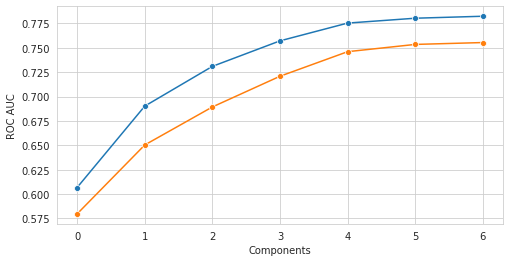

In [ ]:
sns.set_style(style='whitegrid')
plt.figure(figsize=(8, 4))
sns.lineplot(data= roc_train, marker='o')
sns.lineplot(data= roc_test,  marker='o')
plt.xlabel("Components")
plt.ylabel("ROC AUC")

In [ ]:
max(roc_test)

0.755323177570566

The dimensional reduction method did not improve the result.

**Predictions.**

To predict the final result, we will use the initial data and the CatBoost method with the following parameters: depth=5, iterations=500, learning_rate=0.09, l2_leaf_reg=16.

In [ ]:
boosting_model = catboost.CatBoostClassifier(depth=5, iterations=500, learning_rate=0.09, l2_leaf_reg=16)
boosting_model.fit(X, y)
y_pred = boosting_model.predict_proba(X_test)[:, 1]

0:	learn: 0.6011280	total: 65.9ms	remaining: 32.9s
1:	learn: 0.5280023	total: 124ms	remaining: 30.9s
2:	learn: 0.4733971	total: 177ms	remaining: 29.4s
3:	learn: 0.4286379	total: 241ms	remaining: 29.9s
4:	learn: 0.3962235	total: 301ms	remaining: 29.8s
5:	learn: 0.3684529	total: 394ms	remaining: 32.4s
6:	learn: 0.3459314	total: 481ms	remaining: 33.9s
7:	learn: 0.3287155	total: 555ms	remaining: 34.2s
8:	learn: 0.3152582	total: 684ms	remaining: 37.3s
9:	learn: 0.3033399	total: 808ms	remaining: 39.6s
10:	learn: 0.2947364	total: 883ms	remaining: 39.3s
11:	learn: 0.2879559	total: 959ms	remaining: 39s
12:	learn: 0.2824126	total: 1.01s	remaining: 38s
13:	learn: 0.2775194	total: 1.1s	remaining: 38.2s
14:	learn: 0.2737239	total: 1.17s	remaining: 37.9s
15:	learn: 0.2705867	total: 1.27s	remaining: 38.6s
16:	learn: 0.2676171	total: 1.37s	remaining: 39s
17:	learn: 0.2655019	total: 1.5s	remaining: 40.1s
18:	learn: 0.2633686	total: 1.68s	remaining: 42.5s
19:	learn: 0.2617786	total: 1.76s	remaining: 42.

In [ ]:
submission = pd.read_csv('./sample_submission.csv', index_col='SK_ID_CURR')
submission['TARGET'] = y_pred
submission.to_csv('./my_submission.csv')

Result on Kaggle:

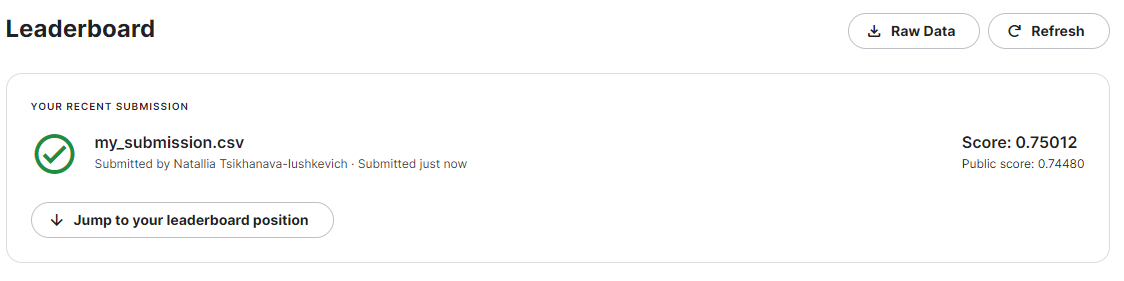

First place score 0.80570.